In [6]:
import pandas as pd
from IPython.display import display
import os
import json
import spacy
from spacy.tokens import Doc
from spacy.lang.pt.examples import sentences 
from newspaper import Article, Source

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt 
from spacy.lang.pt.stop_words import STOP_WORDS

from fuzzywuzzy import fuzz

import requests
from bs4 import BeautifulSoup
import time



/opt/anaconda3/envs/masters/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
nlp = spacy.load('pt_core_news_sm') # commented out once it's loaded

punctuations = list(punctuation)

In [3]:
# Newspapers to search

newsp = ['cmjornal.pt/', 
         'dn.pt/',
         'expresso.pt/',
         'folhanacional.pt/',
         'jn.pt/',
         'ionline.sapo.pt/',   
         'sol.sapo.pt/',
         'observador.pt/',
         'publico.pt/',
         'sabado.pt/',
         'sapo.pt/',
         'visao.pt/',
         ]

not_keywords = ["/multimedia", "/videos", 
                "/famosos", "/celebridades", 
                "/tecnologia", "/boa-vida", 
                "/tendencias", "/desporto",
                "/maissobre", "/ciencia",
                "/cinema", "/cultura",
                "/cidades", "/dinheiro",
                "/blogues", "/podcasts",
                "/vida", "/artes",
                "/iniciativas", "/colunistas/andre",
                "/tribuna"]


In [6]:
def extract_data_from_json(folder_path):
    """
    Extracts 'url' and 'timestamp' from all JSON files in the specified folder and stores them in a DataFrame.
    
    :param folder_path: Path to the folder containing JSON files.
    :return: A pandas DataFrame with columns 'url' and 'timestamp'.
    """
    data = []

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is a JSON file
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            # Open and load the JSON file
            with open(file_path, 'r', encoding='utf-8') as file:
                try:
                    json_data = json.load(file)
                    # Check if the data is a list of dictionaries
                    if isinstance(json_data, list):
                        for entry in json_data:
                            # Extract 'url' and 'timestamp' if available
                            if 'url' in entry and 'timestamp' in entry:
                                data.append({
                                    'url': entry['url'],
                                    'timestamp': entry['timestamp']
                                })
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON file {file_name}: {e}")

    # Convert collected data into a DataFrame
    df = pd.DataFrame(data, columns=['url', 'timestamp'])
    return df


In [42]:
df = extract_data_from_json("/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/cdx_results_json_files/data")

In [6]:
# Use this command to avoid running the code above
df = pd.read_csv('full_dataset.csv')

In [5]:
def filter_links(df, keywords):
    """
    Filters out rows from the DataFrame by assessing each keyword individually.
    Returns the result as a dictionary.
    
    :param df: A pandas DataFrame with at least 'url' and 'timestamp' columns.
    :param keywords: A list of keywords to filter out.
    :return: A dictionary with 'url' and 'timestamp' for rows that do not contain any of the keywords.
    """
    filtered_df = df.copy()

    # Iterate over each keyword and filter rows
    for keyword in keywords:
        filtered_df = filtered_df[~filtered_df['url'].str.contains(keyword, case=False, na=False)]
    
    # Convert the filtered DataFrame to a dictionary
    result_dict = pd.DataFrame(filtered_df)
    return result_dict


In [7]:
df_clean = filter_links(df, not_keywords)

In [8]:
# Function to process the title
def title_input(df): 
    processed_texts = []  # Initialize inside the function

    # Extract the last part of each URL, handling NaN values
    last_part = df['url'].str.rsplit('/').str[-1]  # Extract the last part of the URL
    last_part = last_part.fillna("")  # Replace NaN values with an empty string

    # Handle cases where the last part is empty
    last_part[last_part == ""] = df['url'].str.rsplit('/').str[-2].fillna("")  # Use the second-to-last part if last is empty
    
    for part in last_part:
        if "-" in part:
            parts = part.rsplit('-')[0:-1]  # Split by '-' and remove the last element
            sentence = " ".join(parts)  # Join parts to form a sentence
            processed_sentence = nlp(sentence)  # Process with SpaCy
            processed_texts.append(" ".join(token.text for token in processed_sentence))
        else:
            processed_texts.append("")  # Append an empty string if no processing was done

    # Use .loc to avoid SettingWithCopyWarning
    df = df.copy()  # Create a copy to avoid SettingWithCopyWarning if df is a slice
    df.loc[:, 'processed_url_text'] = processed_texts

    # Update the original DataFrame dictionary with the filtered DataFrame
    df_updated = df
    
    return df

In [9]:
df_clean = title_input(df_clean)

In [11]:
# Function to find the newspaper name in the URL
def find_newspaper(url):
    for newspaper in newsp:
        if newspaper in url:
            return newspaper
    return None  # Return None if no newspaper is found

In [14]:
df_clean['newspaper'] = df_clean['url'].apply(find_newspaper)

In [17]:
df_clean.head()

,url,timestamp,processed_url_text,newspaper
0,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200426174855,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
1,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200427174619,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
2,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200428171922,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
3,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200429172316,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/
4,https://www.cmjornal.pt/c-studio/especiais-c-s...,20200430181128,apoio domiciliario chega a 2200 pessoas por,cmjornal.pt/


In [ ]:
def combine_url_and_timestamp(row):
    """
    Combines the base URL with the 'url' and 'timestamp' columns from a DataFrame row.
    
    :param row: A row from a pandas DataFrame.
    :return: A combined URL string.
    """
    base_url = "https://arquivo.pt/noFrame/replay/"
    return f"{base_url}{row['timestamp']}id_/{row['url']}"

In [19]:
df_clean['arquivo_url'] = df_clean.apply(combine_url_and_timestamp, axis=1)

In [5]:
# Function to filter the dataframe, for links with "chega" and "andre ventura"
def filter_dataframe(df, text_column="processed_url_text"):
    # List to keep track of row indices that meet the criteria
    indices_to_keep = []

    # Iterate over each row in the DataFrame to access both the index and text
    for index, row in df.iterrows():
        text = row[text_column]
        
        # Skip if the text is NaN
        if pd.isna(text):
            continue
        
        doc = nlp(text)

        # Check if "chega" appears as a noun in the document
        is_chega_noun = any(token.text.lower() == "chega" and token.pos_ == "NOUN" for token in doc)

        # Check if both "andre" and "ventura" appear in the document
        contains_andre_ventura = "andre" in text.lower() and "ventura" in text.lower()

        # If either condition is met, keep the row index
        if is_chega_noun or contains_andre_ventura:
            indices_to_keep.append(index)

    # Filter the DataFrame to only include rows that meet the criteria
    df = df.loc[indices_to_keep].reset_index(drop=True)
    
    return df


In [6]:
df_work = filter_dataframe(df_clean)

In [20]:
# Save the DataFrame to a CSV file
df_clean.to_csv('full_ds_title_clean.csv', index=False, encoding='utf-8')

In [ ]:
# Save the DataFrame to a CSV file
df_work.to_csv('working_dataset.csv', index=False, encoding='utf-8')

In [ ]:
# Start from this point
df = pd.read_csv('working_dataset.csv')

In [37]:
# Function to scrape and parse an article
def scrape_article(row):
    """
    Fetches and parses the article content from the given URL.

    :param url: URL of the article.
    :return: A dictionary with the article's title, authors, publish date, and text.
    """
    article = Article(row['url'])
    article.download()  # Download the article content
    article.parse()     # Parse the downloaded content

    return {
        "title": article.title,
        "authors": article.authors,
        "publish_date": article.publish_date,
        "text": article.text
    }

In [ ]:
def scrape_archive_page(row):
    """
    Fetches and parses content from an archived web page, ensuring the final archived URL is used.
    
    :param url: URL of the archived page.
    :param timestamp: Timestamp of the archived URL (from the Arquivo.pt dataset).
    :return: A dictionary with the article's title, authors, publish date, and text.
    """
    try:
        # Set up Selenium WebDriver
        options = webdriver.ChromeOptions()
        options.add_argument("--headless")  # Run in headless mode (no GUI)
        options.add_argument("--disable-gpu")  # Disable GPU for performance
        options.add_argument("--no-sandbox")  # Required for some server environments
        options.add_argument("--blink-settings=imagesEnabled=false")  # Disable images
        options.page_load_strategy = "eager"  # Stop loading after DOMContentLoaded

        driver = webdriver.Chrome(options=options)
        driver.set_page_load_timeout(30)  # Increase page load timeout to 30 seconds

        # Load the initial URL
        driver.get(row['url'])

        # Wait for the page to load fully
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.TAG_NAME, "body"))  # Wait up to 20 seconds
        )

        # Get the final archived URL after all redirects
        final_archived_url = driver.current_url
        print(f"Final archived URL: {final_archived_url}")

        # If the final URL points to a live site, reconstruct the Arquivo.pt link
        if "arquivo.pt" not in final_archived_url:
            final_archived_url = f"https://arquivo.pt/noFrame/replay/{row['timestamp']}/{final_archived_url}"
            print(f"Reconstructed archived URL: {final_archived_url}")

        # Close the driver
        driver.quit()

        # Use newspaper3k to extract content from the reconstructed archived URL
        article = Article(final_archived_url)
        article.download()  # Download content from the final archived URL
        article.parse()  # Parse the downloaded content

        return {
            "title": article.title,
            "authors": article.authors,
            "publish_date": article.publish_date,
            "text": article.text
        }
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        return {
            "title": None,
            "authors": None,
            "publish_date": None,
            "text": None
        }

In [38]:
def scrape_with_duplicates_handling(df):
    """
    Scrapes data from a dataset while avoiding duplicates.
    If a row is processed successfully, subsequent duplicates are skipped.
    
    :param df: Input dataframe with 'url' and other necessary columns.
    :return: A new dataframe with the scraped data.
    """
    processed_urls = set()  # To track processed URLs
    results = []  # To store the scraped results
    
    for _, row in df.iterrows():
        url = row['url']  # Extract the URL from the current row
        
        if url in processed_urls:
            print(f"Skipping duplicate URL: {url}")
            continue  # Skip duplicates
        
        # Attempt to scrape the data
        try:
            scraped_data = scrape_article(row)  # Try live article scraping
            if not scraped_data['title']:  # If scrape_article fails to retrieve meaningful data
                raise ValueError("Empty title from scrape_article")
        except Exception as e:
            print(f"scrape_article failed for URL {url}: {e}")
            try:
                scraped_data = scrape_archive_page(row)  # Fall back to archived page scraping
            except Exception as archive_error:
                print(f"scrape_archive_page also failed for URL {url}: {archive_error}")
                scraped_data = {
                    "title": None,
                    "authors": None,
                    "publish_date": None,
                    "text": None
                }
        
        # If scraping succeeds, add URL to processed and save data
        processed_urls.add(url)
        results.append({**row.to_dict(), **scraped_data})  # Combine original row with scraped data
    
    # Create a new dataframe with the results
    return pd.DataFrame(results)

# Apply the function to the dataset
new_df = scrape_with_duplicates_handling(df)

# Save the new dataset to a file (optional)
new_df.to_csv("scraped_data.csv", index=False)


Skipping duplicate URL: https://www.cmjornal.pt/politica/amp/andre-ventura-do-chega-quer-camaras-nas-fardas-dos-policias
Skipping duplicate URL: https://www.cmjornal.pt/politica/amp/aprovada-proposta-do-chega-para-divulgar-financiamentos-publicos-a-fundacoes-e-associacoes
Skipping duplicate URL: https://www.cmjornal.pt/politica/amp/aprovado-voto-do-chega-para-condenar-agressoes-a-professora-e-assistente-em-setubal
Skipping duplicate URL: https://www.cmjornal.pt/politica/amp/aprovado-voto-do-chega-para-condenar-agressoes-a-professora-e-assistente-em-setubal
Skipping duplicate URL: https://www.cmjornal.pt/politica/amp/aprovado-voto-do-chega-para-condenar-agressoes-a-professora-e-assistente-em-setubal
Skipping duplicate URL: https://www.cmjornal.pt/politica/amp/aprovado-voto-do-chega-para-condenar-agressoes-a-professora-e-assistente-em-setubal
Skipping duplicate URL: https://www.cmjornal.pt/politica/amp/aprovado-voto-do-chega-para-condenar-agressoes-a-professora-e-assistente-em-setubal
Sk

In [4]:
new_df = df = pd.read_csv('scraped_data.csv')

# Remove duplicates based on the 'url' column
df_unique = new_df.drop_duplicates(subset='url', keep='first')

# Print the size of the new DataFrame
print(f"Original DataFrame had {new_df.shape[0]} rows.")
print(f"DataFrame after removing duplicates has {df_unique.shape[0]} rows.")


Original DataFrame had 3663 rows.
DataFrame after removing duplicates has 3663 rows.


In [7]:
# To store removed instances
removed_instances = []

# Function to find and remove similar rows
def remove_similar_entries(df, threshold=50):
    indices_to_remove = set()
    for i, text1 in enumerate(df['text']):
        for j, text2 in enumerate(df['text']):
            if i != j and j not in indices_to_remove:
                similarity = fuzz.ratio(str(text1), str(text2))
                if similarity >= threshold:
                    indices_to_remove.add(j)
                    removed_instances.append({"Index": j, "Text": text2, "Similarity (%)": similarity})
    # Drop the rows from the DataFrame
    df = df.drop(list(indices_to_remove))
    return df

# Apply the function
cleaned_df = remove_similar_entries(new_df)
print(cleaned_df)
# Save the cleaned dataset
#cleaned_df.to_csv("cleaned_dataset.csv", index=False)

# Print removed instances
removed_instances_df = pd.DataFrame(removed_instances)
print(removed_instances_df)
#removed_instances_df.to_csv("removed_instances.csv", index=False)


                                                    url       timestamp  \
0     https://www.cmjornal.pt/politica/amp/andre-ven...  20200124190851   
1     https://www.cmjornal.pt/politica/amp/aprovada-...  20200203181044   
2     https://www.cmjornal.pt/politica/amp/aprovado-...  20200206190139   
4     https://www.cmjornal.pt/politica/amp/comissao-...  20200227012044   
9     https://www.cmjornal.pt/politica/amp/lei-do-ch...  20200210190432   
...                                                 ...             ...   
3472  https://www.publico.pt/2021/11/06/politica/not...  20220125170204   
3480  https://www.publico.pt/2024/03/11/politica/not...  20240325131445   
3481  https://www.publico.pt/2022/08/28/politica/not...  20220828171404   
3613  https://www.sapo.pt/parceiro/noticias-de-vila-...  20220120011049   
3662  https://visao.pt/atualidade/politica/legislati...  20240312015839   

                                     processed_url_text     newspaper  \
0     andre ventura do che

In [9]:
#removed_instances_df.to_csv("removed_instances.csv", index=False)
#cleaned_df.to_csv("cleaned_dataset.csv", index=False)

print(cleaned_df)

                                                    url       timestamp  \
0     https://www.cmjornal.pt/politica/amp/andre-ven...  20200124190851   
1     https://www.cmjornal.pt/politica/amp/aprovada-...  20200203181044   
2     https://www.cmjornal.pt/politica/amp/aprovado-...  20200206190139   
4     https://www.cmjornal.pt/politica/amp/comissao-...  20200227012044   
9     https://www.cmjornal.pt/politica/amp/lei-do-ch...  20200210190432   
...                                                 ...             ...   
3472  https://www.publico.pt/2021/11/06/politica/not...  20220125170204   
3480  https://www.publico.pt/2024/03/11/politica/not...  20240325131445   
3481  https://www.publico.pt/2022/08/28/politica/not...  20220828171404   
3613  https://www.sapo.pt/parceiro/noticias-de-vila-...  20220120011049   
3662  https://visao.pt/atualidade/politica/legislati...  20240312015839   

                                     processed_url_text     newspaper  \
0     andre ventura do che

In [10]:
# Empty dictionary to introduce the tokens
lemmas_dict = {}

stop_words = {'comprida', 'lá', 'mesmo', 'ela', 'de', 'quero', 'vão', 'nesta', 'em', 'com', 'tais', 'neste', 'obrigado', 'bom', 'for', 'vai', 'fazer', 'tens', 'alguns', 'todos', 'tu', 'muito', 'estás', 'deve', 'novas', 'todo', 'foste', 'pode', 'pontos', 'pegar', 'quieto', 'seria', 'eles', 'coisa', 'faz', 'sou', 'daquela', 'tua', 'suas', 'teu', 'cuja', 'esses', 'vindo', 'aquele', 'um', 'certamente', 'essa', 'no', 'vens', 'também', 'maiorias', 'fostes', 'tanta', 'elas', 'desse', 'diante', 'pelas', 'nove', 'quinta', 'maior', 'do', 'quando', 'aqueles', 'desta', 'sabe', 'ambas', 'que', 'tentar', 'estes', 'próximo', 'povo', 'sem', 'uns', 'tão', 'além', 'geral', 'porquanto', 'fora', 'vêm', 'tivemos', 'depois', 'ir', 'ora', 'tarde', 'nessa', 'da', 'nós', 'ver', 'tiveram', 'tem', 'cada', 'exemplo', 'número', 'meus', 'tuas', 'conhecido', 'cento', 'devem', 'para', 'fomos', 'à', 'favor', 'quanto', 'teve', 'apenas', 'este', 'vais', 'mas', 'querem', 'lugar', 'vinte', 'quê', 'após', 'apoio', 'mal', 'quarta', 'grande', 'adeus', 'pelos', 'parece', 'dezanove', 'ligado', 'sob', 'estou', 'ao', 'final', 'talvez', 'demais', 'aos', 'agora', 'você', 'nem', 'maioria', 'vez', 'treze', 'menor', 'temos', 'possível', 'ambos', 'não', 'isto', 'dezoito', 'tempo', 'estas', 'área', 'nenhuma', 'fui', 'estará', 'cujo', 'faço', 'bem', 'logo', 'quais', 'onde', 'menos', 'aquela', 'quatro', 'outras', 'pouca', 'dar', 'dezasseis', 'último', 'valor', 'é', 'antes', 'aqui', 'mais', 'sétimo', 'dizem', 'estão', 'veja', 'dezassete', 'ele', 'tivestes', 'tive', 'quarto', 'nova', 'bastante', 'pois', 'apoia', 'outra', 'teus', 'caminho', 'fazeis', 'lado', 'somente', 'esteve', 'fazemos', 'nesse', 'dessa', 'numa', 'qualquer', 'momento', 'assim', 'esse', 'boa', 'pôde', 'duas', 'longe', 'meio', 'saber', 'és', 'ponto', 'daquele', 'estava', 'irá', 'perto', 'num', 'aí', 'umas', 'nossas', 'falta', 'o', 'dão', 'quer', 'custa', 'tipo', 'sexto', 'vinda', 'segundo', 'sétima', 'ter', 'seu', 'poder', 'enquanto', 'algo', 'sois', 'se', 'poderá', 'grandes', 'naquele', 'dá', 'novos', 'tanto', 'cedo', 'vossas', 'cima', 'posição', 'era', 'na', 'ser', 'vossos', 'seis', 'terceira', 'fim', 'onze', 'disso', 'tentei', 'iniciar', 'minha', 'apontar', 'estiveram', 'quem', 'fará', 'até', 'sexta', 'zero', 'pouco', 'então', 'sei', 'vossa', 'ainda', 'nuns', 'parte', 'sua', 'a', 'mês', 'acerca', 'terceiro', 'primeiro', 'estar', 'oitava', 'grupo', 'porquê', 'contra', 'me', 'forma', 'dizer', 'sete', 'toda', 'dois', 'portanto', 'estado', 'podia', 'vos', 'máximo', 'vocês', 'comprido', 'tenho', 'baixo', 'somos', 'através', 'são', 'quinto', 'nada', 'segunda', 'outros', 'sempre', 'vosso', 'certeza', 'debaixo', 'oitavo', 'lhe', 'dos', 'mil', 'têm', 'desde', 'nível', 'nos', 'usar', 'primeira', 'fazes', 'fazia', 'tiveste', 'deste', 'corrente', 'oito', 'vós', 'doze', 'das', 'sistema', 'inclusive', 'já', 'vem', 'contudo', 'minhas', 'cinco', 'estivestes', 'naquela', 'nas', 'vários', 'tal', 'fazem', 'tentaram', 'posso', 'estiveste', 'direita', 'isso', 'embora', 'pela', 'uma', 'breve', 'nossa', 'números', 'nossos', 'essas', 'dentro', 'deverá', 'partir', 'próxima', 'eventual', 'conselho', 'às', 'esta', 'foi', 'só', 'te', 'possivelmente', 'obrigada', 'relação', 'meses', 'três', 'põem', 'quieta', 'fez', 'ali', 'aquilo', 'sobre', 'qual', 'atrás', 'estive', 'está', 'sim', 'estivemos', 'todas', 'cá', 'ou', 'muitos', 'porque', 'foram', 'algumas', 'pelo', 'por', 'tente', 'questão', 'nosso', 'local', 'novo', 'nunca', 'como', 'meu', 'tudo', 'porém', 'as', 'vezes', 'usa', 'os', 'diz', 'e', 'dez', 'ademais', 'seus', 'conhecida', 'ontem', 'quinze', 'põe', 'des', 'entre', 'eu', 'catorze', 'próprio', 'tendes', 'aquelas', 'podem', 'inicio', 'puderam', 'de o', 'correio', ' ', 'manhã', 'a o', 'comentário', 'conteúdo', 'espaço', 'leitor'}

# Loop through each review along with its index
for index, row in cleaned_df.iterrows():
    text = row['text']  # Access the 'text' column
    if text is None or not isinstance(text, str):
        print(f"Skipping index {index} because the review is None")
        continue
    doc = nlp(text)
    lemmas = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    lemmas = [ word for word in lemmas if word not in stop_words and word not in punctuations ]
    lemmas_dict[index] = lemmas  # Store lemmas in the dictionary with index as key

# Convert dictionary to a series and assign as a new column in the DataFrame
df_unique['Lemmas'] = pd.Series(lemmas_dict)


       Word  Frequency
0      em o       1251
1                  938
2         “        564
3         ”        552
4     chega        536
5   ventura        487
6   partido        455
7     andré        345
8     por o        302
9  deputado        217


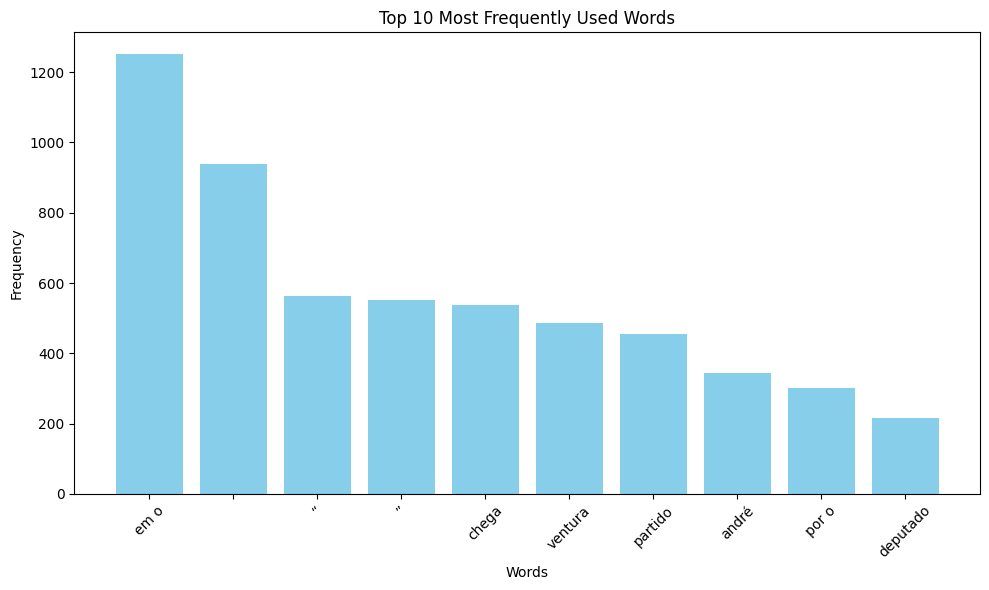

In [11]:
# Ensure all values in 'Lemmas' column are lists
df_unique['Lemmas'] = df_unique['Lemmas'].apply(lambda x: x if isinstance(x, list) else [])

# Word Count
def w_counter(words):
    word_freq = Counter(words)
    common_words = word_freq.most_common()
    word_freq_dict = {"Word": [word for word, freq in common_words], "Frequency": [freq for word, freq in common_words]}
    return word_freq_dict

all_words = [word for sublist in df_unique['Lemmas'] for word in sublist]

word_freq = pd.DataFrame(w_counter(all_words))

# Select the top 10 words by frequency
top_10_words = word_freq.head(10)
print(top_10_words)
# Plot the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(top_10_words['Word'], top_10_words['Frequency'], color='skyblue')
plt.title("Top 10 Most Frequently Used Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
def extract_ngrams(texts, n=2):
    """
    Extract n-grams (bigrams or trigrams) from a list of texts.
    
    Parameters:
    texts (list): List of sentences or reviews to extract n-grams from.
    n (int): Number of words in each n-gram (e.g., 2 for bigrams, 3 for trigrams).
    
    Returns:
    Counter: Frequency count of n-grams.
    """
    ngrams = []
    for doc in nlp.pipe(texts):  # Process each text in the list with SpaCy
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        # ngrams += zip(*[tokens[i:] for i in range(n)])  # Create n-grams

        # This way we ensure the n grams are all of the specified length
        ngrams += [ngram for ngram in zip(*[tokens[i:] for i in range(n)]) if len(ngram) == n] 
    
    return Counter(ngrams)

# Example usage with bigrams and trigrams

df_unique['Lemma_String'] = df_unique['Lemmas'].apply(lambda lemmas: " ".join(lemmas))

# Extract bigrams
bigram_counts = extract_ngrams(df_unique['Lemma_String'], n=2)
print("Top 10 Bigrams:", bigram_counts.most_common(10))

# Extract trigrams
trigram_counts = extract_ngrams(df_unique['Lemma_String'], n=3)
print("Top 10 Trigrams:", trigram_counts.most_common(10))


Top 10 Bigrams: [(('andré', 'ventura'), 342), (('líder', 'chega'), 64), (('assembleia', 'república'), 58), (('antónio', 'costa'), 38), (('chega', 'andré'), 37), (('deputado', 'chega'), 35), (('presidente', 'república'), 35), ((' ', 'andré'), 34), (('rede', 'social'), 34), (('rui', 'rio'), 34)]
Top 10 Trigrams: [(('chega', 'andré', 'ventura'), 37), ((' ', 'andré', 'ventura'), 34), (('marcelo', 'rebelo', 'sousa'), 32), ((' ', 'pub', ' '), 25), (('presidente', 'assembleia', 'república'), 19), (('joacine', 'katar', 'moreira'), 19), (('andré', 'ventura', ' '), 18), (('deputado', 'único', 'chega'), 13), (('partido', 'andré', 'ventura'), 11), (('andré', 'ventura', 'afirmar'), 10)]


In [ ]:
print("Top 10 Bigrams:", bigram_counts.most_common(50))


print("Top 10 Trigrams:", trigram_counts.most_common(50))

Top 10 Bigrams: [(('andré', 'ventura'), 4056), (('assembleia', 'república'), 2160), (('único', 'exclusivo'), 1727), ((' ', 'reconhecer'), 1665), (('assinante', 'premium'), 1660), (('referir', 'suporte'), 1660), (('direto', 'indireta'), 1660), (('indireta', 'explícito'), 1660), (('explícito', 'implícito'), 1660), (('reservar', 'direito'), 1660), (('presente', 'regra'), 1660), (('regra', ' '), 1660), (('deputado', 'único'), 1002), ((' ', 'andré'), 1002), ((' ', 'caso'), 880), (('racismo', 'xenofobia'), 868), (('prática', 'ato'), 863), (('xenofobia', 'discriminação'), 860), (('violar', 'direito'), 847), (('cumpr', 'regra'), 836), ((' ', 'vir'), 834), ((' ', 'possibilidade'), 833), (('responsabilidade', 'civil'), 831), (('ódio', 'racismo'), 831), (('caso', 'violação'), 831), (('ferro', 'rodrigues'), 830), (('oferecer', 'artigo'), 830), (('artigo', 'considerar'), 830), (('considerar', 'essencial'), 830), (('essencial', 'reflexão'), 830), (('reflexão', 'debate'), 830), (('debate', 'livre'), 

Bear in mind that a lot of the bigrams and trigrams aren't relevant (they're associated with subscription, reading, and a lot of them have the same number of hits, which means it might make sense to remove them to see what is beneath.)

In [27]:
least_common_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1])[:50]
print("Least 50 Common Bigrams:", least_common_bigrams)

# Display the least common trigrams
least_common_trigrams = sorted(trigram_counts.items(), key=lambda x: x[1])[:50]
print("Least 50 Common Trigrams:", least_common_trigrams)

Least 50 Common Bigrams: [(('resolução', 'defender'), 1), (('defender', 'agente'), 1), (('segurança', 'nacional'), 1), (('dever', 'utilizar'), 1), (('utilizar', 'câmara'), 1), (('câmara', 'fardo'), 1), (('fardo', 'carros-patrulha'), 1), (('carros-patrulha', 'avançar'), 1), (('i.', 'partido'), 1), (('medida', 'objetivo'), 1), (('objetivo', 'avaliar'), 1), (('situação', 'independente'), 1), (('independente', 'evitandor'), 1), (('evitandor', 'troca'), 1), (('troca', 'acusação'), 1), (('acusação', 'força'), 1), (('segurança', 'cidadão'), 1), (('cidadão', 'acusar'), 1), (('acusar', 'brutalidade'), 1), (('brutalidade', 'chega'), 1), (('afirmar', 'método'), 1), (('método', 'ajudar'), 1), (('ajudar', 'proteger'), 1), (('proteger', 'polícia'), 1), (('polícia', 'tornar'), 1), (('tornar', 'atuação'), 1), (('atuação', 'transparente'), 1), (('transparente', 'proposta'), 1), (('proposta', 'chegar'), 1), (('chegar', 'altura'), 1), (('altura', 'força'), 1), (('policial', 'encontrar'), 1), (('encontrar